<a href="https://www.kaggle.com/code/palpriyanshu/indian-college-placement-and-salary-prediction?scriptVersionId=293966935" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-engineering-college-placement-dataset/placement_targets.csv
/kaggle/input/indian-engineering-college-placement-dataset/indian_engineering_student_placement.csv


In [2]:
import pandas as pd
import numpy as np

students = pd.read_csv("/kaggle/input/indian-engineering-college-placement-dataset/indian_engineering_student_placement.csv")
targets = pd.read_csv("/kaggle/input/indian-engineering-college-placement-dataset/placement_targets.csv")
print(students.head())
print(targets.head())

   Student_ID  gender branch  cgpa  tenth_percentage  twelfth_percentage  \
0           1    Male    ECE  8.74              74.0                75.0   
1           2  Female    ECE  7.80              75.3                69.7   
2           3  Female     IT  6.95              62.8                68.3   
3           4    Male    ECE  7.46              57.9                51.4   
4           5    Male     IT  6.86              61.3                73.5   

   backlogs  study_hours_per_day  attendance_percentage  projects_completed  \
0         0                  3.8                   71.1                   7   
1         0                  6.3                   69.5                   5   
2         0                  1.5                   62.5                   8   
3         1                  4.7                   64.6                   6   
4         2                  5.2                   75.9                   3   

   ...  aptitude_skill_rating  hackathons_participated  certificatio

In [3]:
#Merge Features & Targets
data = students.merge(targets, on="Student_ID")


In [4]:
#Basic data cleaning
data.isnull().sum()

num_cols = data.select_dtypes(include=np.number).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

cat_cols = data.select_dtypes(include="object").columns
data[cat_cols] = data[cat_cols].fillna("Unknown")


In [5]:
#encoding categorical features
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in cat_cols:
    data[col] = encoder.fit_transform(data[col])


In [6]:
#placement prediction
X = data.drop(["Student_ID", "placement_status", "salary_lpa"], axis=1)
y = data["placement_status"]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [8]:
from lightgbm import LGBMClassifier

placement_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight="balanced",
    random_state=42
)

placement_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 3442, number of negative: 558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1240
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=300,
               random_state=42)

In [9]:
from sklearn.metrics import accuracy_score, f1_score

preds = placement_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print("F1 Score:", f1_score(y_test, preds))


Accuracy: 0.863
F1 Score: 0.919836161497952


In [10]:
#salary prediction
placed_data = data[data["placement_status"] == 1]

X_reg = placed_data.drop(["Student_ID", "placement_status", "salary_lpa"], axis=1)
y_reg = placed_data["salary_lpa"]


In [11]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [12]:
from lightgbm import LGBMRegressor

salary_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

salary_model.fit(Xr_train, yr_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1240
[LightGBM] [Info] Number of data points in the train set: 3442, number of used features: 22
[LightGBM] [Info] Start training from score 16.123942


LGBMRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score

salary_preds = salary_model.predict(Xr_test)

print("MAE:", mean_absolute_error(yr_test, salary_preds))
print("R2 Score:", r2_score(yr_test, salary_preds))


MAE: 1.146804726149716
R2 Score: 0.7514259751079517


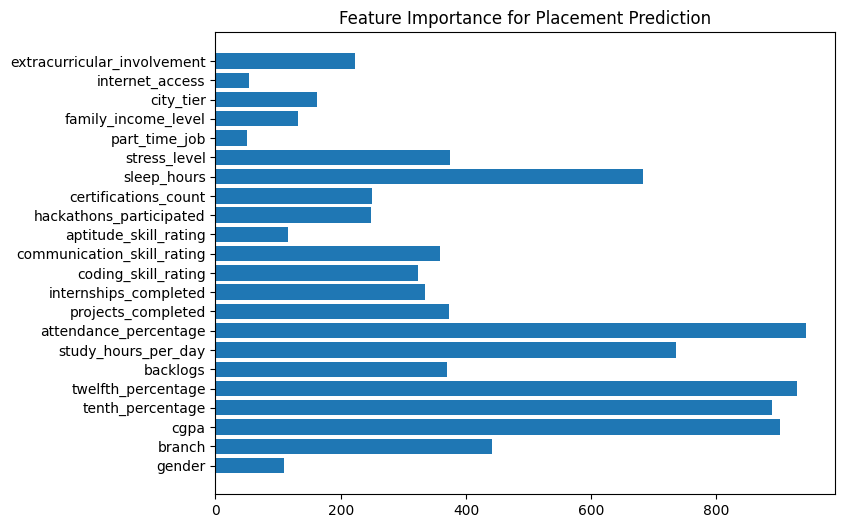

In [14]:
import matplotlib.pyplot as plt

importances = placement_model.feature_importances_
features = X.columns

plt.figure(figsize=(8,6))
plt.barh(features, importances)
plt.title("Feature Importance for Placement Prediction")
plt.show()
